# Suggest

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) data structure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on a trie;
3. Measure suggestion speed;

![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

## 0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [1]:
%pip install pygtrie nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: C:\Users\Aleksandr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import pygtrie
import nltk
import gzip
from tqdm import tqdm
from nltk.corpus import stopwords

## 1. Build a trie upon a dataset

### 1.1. [5] Read the dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset. Pass the assert.

In [3]:
!wget https://github.com/IUCVLab/information-retrieval/raw/main/datasets/aol/user-ct-test-collection-01.txt.gz
with gzip.open("user-ct-test-collection-01.txt.gz") as f:
    contents = f.read()
    with open("./user-ct-test-collection-01.txt", "wb+") as f:
        f.write(contents)
    DATASET_PATH = "./user-ct-test-collection-01.txt"

Connecting to github.com (140.82.121.4:443)
Connecting to raw.githubusercontent.com (185.199.109.133:443)
wget: can't open 'user-ct-test-collection-01.txt.gz': File exists


In [4]:
aol_data = pd.read_csv(DATASET_PATH, sep='\t')
aol_data.head()

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,142,rentdirect.com,2006-03-01 07:17:12,NaN,NaN
1,142,www.prescriptionfortime.com,2006-03-12 12:31:06,NaN,NaN
2,142,staple.com,2006-03-17 21:19:29,NaN,NaN
3,142,staple.com,2006-03-17 21:19:45,NaN,NaN
4,142,www.newyorklawyersite.com,2006-03-18 08:02:58,NaN,NaN


In [5]:
aol_data['ItemRank'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3558411 entries, 0 to 3558410
Series name: ItemRank
Non-Null Count    Dtype  
--------------    -----  
1890568 non-null  float64
dtypes: float64(1)
memory usage: 27.1 MB


In [6]:
assert aol_data.shape[0] == 3558411, "Dataset size does not match"

### 1.2. [10] Build a Trie

We want a suggest function to be **non-sensitive to stop words** because we don't want to upset the users if they confuses/omits prepositions. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build a Trie based on the dataset, **storing query statistics such as query _frequency_, urls and ranks in the nodes**. Some queries may have no associated urls, others may have multiple ranked urls. Think of the way to store this information.

Pass the asserts.

In [7]:
class TrieNode:
    """ Represents a node in the Trie data structure. """

    def __init__(self):
        """ Initialize this node in the Trie. """
        self.frequencies = list() # list of frequencies
        self.urls = list() # list of urls
        self.ranks = list() # list of ranks
        self.queries = list() # list of full-text queries
        
    
    def add(self, frequency, url, rank, query):
        self.frequencies.append(frequency)
        self.urls.append(url)
        self.ranks.append(rank)
        self.queries.append(query)
        return self

    def __str__(self):
        return f"TrieNode[{self.frequencies[:5]}, {self.queries[:5]}]"

    def __repr__(self):
        return f"TrieNode[{self.frequencies[:5]}, {self.queries[:5]}]"


In [8]:
stops = set('a on at of to is from for and with using the in &'.split())

def filter_query(query):
    if pd.isnull(query) or pd.isna(query):
        return None
    return " ".join(filter(lambda x: x not in stops, query.split()))

In [9]:
data = aol_data.copy()
data['ShortQuery'] = data['Query'].copy()
data['ShortQuery'] = data['ShortQuery'].apply(filter_query) 
data['ClickURL'] = data['ClickURL'].apply(lambda x: None if pd.isna(x) else x) 
data['ItemRank'] = data['ItemRank'].apply(lambda x: None if pd.isna(x) else x) 

aol_trie = pygtrie.CharTrie()
F = data.ShortQuery.value_counts().to_dict()

In [10]:
data.sample(5)

,AnonID,Query,QueryTime,ItemRank,ClickURL,ShortQuery
1412931,3541615,el paso texas telephone white pages,2006-05-27 15:37:45,NaN,None,el paso texas telephone white pages
1248248,3126217,billyjack.com,2006-04-04 12:29:44,2.0,http://www.billyjack.com,billyjack.com
1152188,2884498,gambling corporation,2006-05-12 08:49:40,NaN,None,gambling corporation
2924811,12523704,colombine,2006-04-19 21:13:05,NaN,None,colombine
2508790,8957027,baileysirishcream,2006-03-18 12:18:29,NaN,None,baileysirishcream


In [11]:
for i, row in tqdm(data.iterrows(), total=len(data.index)):
    if row.ShortQuery is None: continue
    if row.ShortQuery in aol_trie:
        node = aol_trie[row.ShortQuery]
        node.add(F[row.ShortQuery], row.ClickURL, row.ItemRank, row.Query)
        aol_trie[row.ShortQuery] = node
    else: 
        aol_trie[row.ShortQuery] = TrieNode()
        aol_trie[row.ShortQuery] = aol_trie[row.ShortQuery].add(F[row.ShortQuery], row.ClickURL, row.ItemRank, row.Query)

100%|██████████| 3558411/3558411 [06:19<00:00, 9376.97it/s] 


In [12]:
# test trie
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)
    
    #NB: here we assume you store urls in a property of list type. But you can do something different. 
    bag += val.urls
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ TrieNode[[5, 5, 5, 5, 5], ['sample question surveys', 'sample question surveys', 'sample question surveys', 'sample question surveys', 'sample question surveys']]
sample questions immigration interview ~ TrieNode[[1], ['sample questions for immigration interview']]
sample questions interview ~ TrieNode[[1], ['sample questions for interview']]
sample questions family interview ~ TrieNode[[3, 3, 3], ['sample questions for family interview', 'sample questions for family interview', 'sample questions for family interview']]
sample questions sociology race ethnicity ~ TrieNode[[1], ['sample questions sociology race and ethnicity']]
sample questions biology ~ TrieNode[[2, 2], ['sample questions biology', 'sample questions biology']]
sample questions us citizenship test ~ TrieNode[[1], ['sample questions for us citizenship test']]
sample questionarie teaching evaluation ~ TrieNode[[1], ['sample questionarie teaching evaluation']]
sample questionnaire teaching evaluat

## 2. [15] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Pass the asserts.

Question for analysis: What is the empirical threshold for minimal prefix for suggest?

In [13]:
stops = set('a on at of to is from for and with using the in &'.split())

In [14]:
from collections import defaultdict

def complete_user_query(query: str, trie, top_k=5, disable_bar=False, verbose=False) -> list[str]:
    """Complete user query using trie

    Args:
        query (str): user query
        trie (pygtrie.CharTrie): trie with queries
        top_k (int, optional): number of suggestions. Defaults to 5.
        disable_bar (bool, optional): disable progress bar. Defaults to False.
        verbose (bool, optional): print suggestions. Defaults to False.
    
    Returns:
        list[str]: list of suggestions
    """
    
    query = " ".join(filter(lambda x: x not in stops, query.split()))
    if not trie.has_subtrie(query):
        return []
    keys = defaultdict(lambda: 0)
    nodes = defaultdict(lambda: [])    

    for key, node in tqdm(list(trie.iteritems(query)), desc=f"Searching for suggests for \"{query}\" ...", disable=disable_bar):
        keys[key] += sum(node.frequencies)
        nodes[key].extend(list(zip(node.queries, node.urls, node.ranks)))
    keys = list(keys.items())
    keys.sort(key=lambda x: x[1], reverse=True)
   
    suggestions = [nodes[x[0]] for x in keys[:top_k]]
    output_queries = []
    output_urls = []
    output_ranks = []
    for suggestion in suggestions:
        result_query = suggestion[0][0]
        suggestion_url = None
        url_rank = -1
        for q, u, r in suggestion:
            if r > url_rank: 
                suggestion_url = u
                result_query = q
        output_queries.append(result_query)
        output_urls.append(suggestion_url)
        output_ranks.append(url_rank)

    if verbose:
        for q, u in zip(output_queries, output_urls): 
            if u is not None:
                print(f"Query: {q}, url: {u}")
            else:
                print(f"Query: {q}, no url found")
    return output_queries

    
        
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie, verbose=True, disable_bar=True)
print(res)


#NB we assume you return suggested query string only
assert res[0] == "tried and true tattoo"
assert res[1] == "triest" or res[1] == "triethanalomine"

assert "boys and girls club of conyers georgia" \
            in complete_user_query("boys girls club conyers", aol_trie, 10, verbose=True, disable_bar=True), "Should be here"

Query: trie
Results:
Query: tried and true tattoo, url: http://www.triedntruetattoo.com
Query: triest, no url found
Query: triethanalomine, url: http://www.amazon.com
Query: tried and failed, no url found
Query: tried and truechildren's consignment sale, no url found
['tried and true tattoo', 'triest', 'triethanalomine', 'tried and failed', "tried and truechildren's consignment sale"]
Query: boys and girls club of conyers georgia, url: http://www.bgcma.org


## 3. Measure suggest speed ##

### 3.1. [10] Full Trie test

Check how fast your search is working. Consider changing your code if it takes too long on average.

Sucess criterion:
- there is an average and a standard deviation for **multiple runs** of the given bucket.
- there is an average and a standard deviation for **multiple runs** of naive search in the unindexed dataset.

In [15]:
# get all queries from dataset
all_queries_short = data['ShortQuery'][data['ShortQuery'].notnull()].unique()
len(all_queries_short)

1210003

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt


inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]


def no_index_search(query):
    """Search for queries in `all_queries_short` whose prefix is equal to `query`

    Args:
        query (str): query to search for

    Returns:
        list[str]: list of queries whose prefix is equal to `query`
    """
    query = filter_query(query)
    queries = []
    for q in all_queries_short:
        if q.startswith(query):
            queries.append(q)
    queries.sort(key=F.__getitem__)
    return queries

def trie_index_search(query):
    """Search for queries in `aol_trie` whose prefix is equal to `query`

    Args:
        query (str): query to search for
    
    Returns:
        list[str]: list of queries whose prefix is equal to `query`
    """
    query = filter_query(query)
    queries = []
    if not aol_trie.has_subtrie(query):
        return []
    for q in aol_trie.iteritems(query):
        queries.append(q[0])
    return queries

def estimate_performance(search_function, num_calls=100, queries=inp_queries):
    """Estimate performance of `search_function` by running it `num_calls` times

    Args:
        search_function (function): function to estimate performance of
        num_calls (int, optional): number of calls to `search_function`. Defaults to 100.
        queries (list[str], optional): queries to search for. Defaults to inp_queries.

    Returns:
        tuple[np.ndarray, np.ndarray]: mean and standard deviation of time for each query
    """
    times = []
    with tqdm(queries, desc=f"Running queries with `{search_function.__name__}` ...") as t:

        for query in t:
            t.set_postfix_str(f"Query: {query}")
            times.append([])
            for _ in range(num_calls):
                start = time.time()
                search_function(query)
                end = time.time()
                times[-1].append(end - start)
    return np.mean(times, axis=1), np.std(times, axis=1)

trie_index_mean, trie_index_std = estimate_performance(trie_index_search, num_calls=100, queries=inp_queries)
no_index_mean, no_index_std = estimate_performance(no_index_search)

Running queries with `no_index_search` ...: 100%|██████████| 11/11 [01:55<00:00, 10.51s/it, Query: Barbara ]            


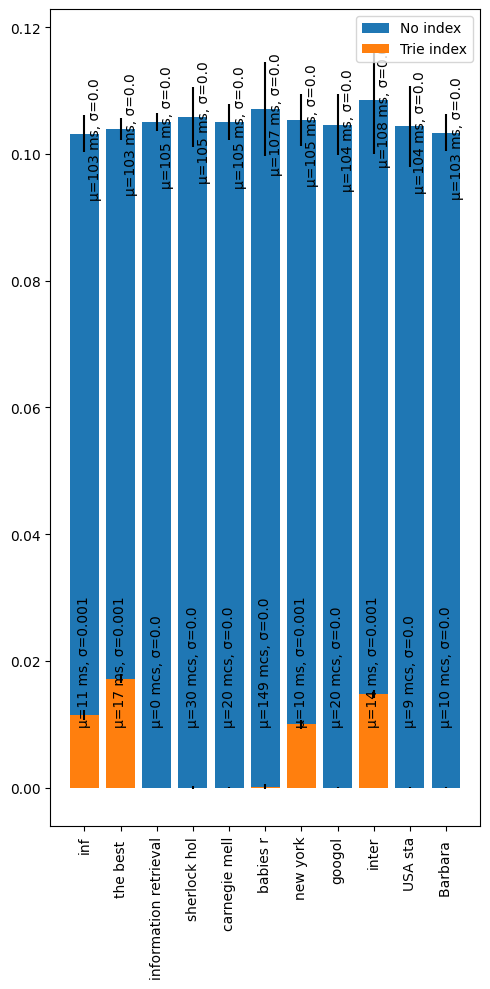

In [17]:
plt.figure(figsize=(5, 10))
plt.bar(np.arange(len(inp_queries)), no_index_mean, yerr=no_index_std, label="No index")
plt.bar(np.arange(len(inp_queries)), trie_index_mean, yerr=trie_index_std, label="Trie index")
plt.xticks(np.arange(len(inp_queries)), inp_queries, rotation=90)
fmt = lambda x: f"{x} s" if x > 1 else f"{int(x * 1000)} ms" if x > 1E-3 else f"{int(x * 1E6)} mcs" 
for i, (v, s) in enumerate(zip(trie_index_mean, trie_index_std)):
    plt.text(i - 0.2, max(0.01, v - 0.01), f"μ={fmt(v)}, σ={round(s, 3)}", rotation=90)
for i, v in enumerate(no_index_mean):
    plt.text(i + 0.1, max(0.01, v - 0.01), f"μ={fmt(v)}, σ={round(s, 3)}", rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## 4. [10] Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

You can use use [pyspellchecker](https://pypi.org/project/pyspellchecker/) `candidates()` call, or use any other spellchecker implementation.

In [18]:
%pip install pyspellchecker pylcs


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: C:\Users\Aleksandr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
import spellchecker
from itertools import product

# load words from queries to spellchecker
# using edit distance 1 to make results
# as close to original as possible
vocab_words = list()
cor = spellchecker.SpellChecker(language=None, distance=1, local_dictionary={})
for additional_words in data.Query[data.Query.notna()]:
    vocab_words.extend(additional_words.split())

# load words from queries to spellchecker
cor.word_frequency.load_words(vocab_words)
# create set of words for fast check if word is in vocab
vocab = set(vocab_words)


def corrections(word):
    """Get possible corrections for word from vocab.
    
    Args:
        word (str): word to correct

    Returns:
        list[str]: list of possible corrections
    """
    return list(filter(lambda x: x in vocab, cor.edit_distance_1(word))) + [word]

def freq_score(words):
    """Get frequency score for list of words.

    Args:
        words (list[str]): list of words
    
    Returns:
        int: sum of frequencies for all words
    """
    return sum(map(cor.word_frequency.__getitem__, words))

def complete_user_query_with_spellchecker(query, trie, top_k=5) -> list[str]:
    # correct query first with pyspellchecker
    # then search in trie
    # return top-k results
    words = query.split()
    # produce all the combinations of words with corrected candidates
    corrected_words = list(product(*[corrections(x) for x in words[:-1]]))
    best_correction = list(max(corrected_words, key=freq_score))
    best_correction.append(words[-1])
    query = " ".join(best_correction)
    if not trie.has_subtrie(query):
        return []
    keys = defaultdict(lambda: 0)
    for item in tqdm(list(trie.iteritems(query)), desc=f"Searching for suggests for \"{query}\" ..."):
        keys[item[1].queries[0]] += sum(item[1].frequencies)
    keys = list(keys.items())
    keys.sort(key=lambda x: x[1], reverse=True)
    return [x[0] for x in keys[:top_k]]

580462


In [22]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]

for q, qc in zip(inp_queries, inp_queries_corrected):
    assert complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5), "Assert {} and {} give different results".format(q, qc)

Searching for suggests for "babies r" ...: 100%|██████████| 36/36 [00:00<?, ?it/s]
